# Trend-following benchmark summary

This notebook displays the performance of trend-following strategies across major asset classes. Note that the all backtest should be taken with a grain of salt because the future contract may not be as liquid as what the backtest assumes.

In [1]:
%matplotlib inline
import re 

import pandas as pd
import matplotlib.pyplot as plt

from adagio.stats.performance import Performance, PerfStats
from adagio.utils import keys
from adagio.utils.const import FuturesInfo
from adagio.utils.mongo import get_library

Connect to the database where the backtest result is saved.

In [2]:
library = get_library(keys.backtest)

# Load backtest

In [3]:
engine_symbol = library.list_symbols(name='Trend-following benchmark')[0]
engine_item = library.read(engine_symbol)
engine = engine_item.data

In [4]:
def rename_contract(column_name):
    """ Convert key name into full name """
    fut_key = re.search('[A-Z]+_[A-Z]+', column_name)
    
    try:
        return FuturesInfo[fut_key.group(0)].value.full_name
    except AttributeError:
        return column_name
    
def rename_sub_returns(column_name):
    """ Rename strategy sub returns name """
    name = re.search('\([\w\s\-]+\)', column_name)
    
    try:
        name = name.group(0).replace('(', '').replace(')', '')
        return name
    except AttributeError:
        return column_name

# Measure performance

In [5]:
sub_net_returns = engine.get_sub_net_returns()
final_net_returns = engine.get_final_net_returns()
contract_net_returns = pd.concat([engine_sub.get_sub_net_returns() 
                                  for engine_sub in engine[0]], axis=1)

In [6]:
contract_net_returns = contract_net_returns.rename(columns=rename_contract)
sub_net_returns = sub_net_returns.rename(columns=rename_sub_returns)

## Trend-following portfolio

This portfolio consists of:
- Equity index futures (both DM and EM)
- Government bond futures
- FX futures (both DM and EM)
- Commodity futures (energy, grains, softs, agri, metals)

where the same trend detection method is applied. The method used here is a simple exponentially-weighted moving average cross-over. Basically it takes long position if the short-term moving average is higher than the long-term one.

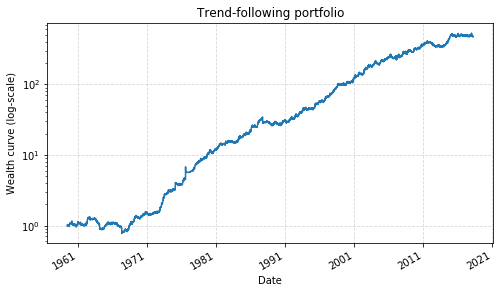

In [7]:
fig, ax = plt.subplots(figsize=(8, 4.5))
final_net_returns.add(1).cumprod().plot(logy=True, ax=ax);
ax.set_title('Trend-following portfolio')
ax.set_ylabel('Wealth curve (log-scale)');

In [8]:
final_net_returns.add(1).cumprod().pipe(Performance).summary()

,final_net_returns (Trend-following benchmark)
annualised return,0.109663
annualised vol,0.114270
Sharpe ratio,0.959679
max drawdown,0.413798
Calmar ratio,0.265015
skewness,5.026599
kurtosis,246.162178


## Performance breakdown by futures contract

Most of the contracts contributed positively when trend-following is applied.

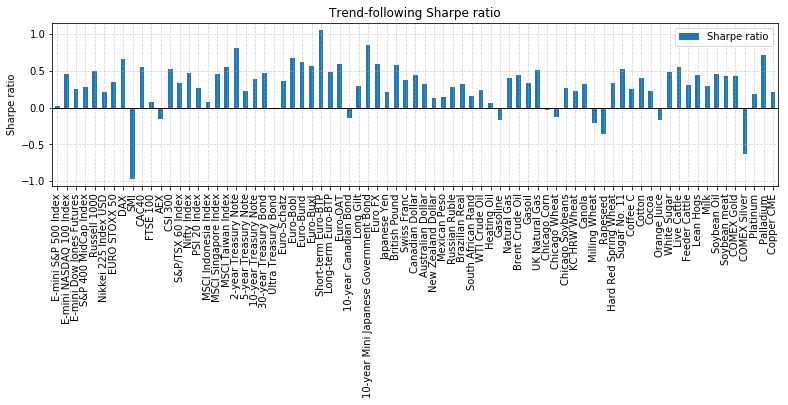

In [9]:
fig, ax = plt.subplots(figsize=(13, 3))
(contract_net_returns.add(1).cumprod().pipe(Performance).summary()
 .loc[PerfStats.SHARPE.value, :]
 .to_frame()
 .plot(kind='bar', ax=ax));

ax.set_title('Trend-following Sharpe ratio')
ax.set_ylabel(PerfStats.SHARPE.value);
ax.axhline(0, color='black', lw=1);

## Performance breakdown by asset class

Trend-following for metal futures is the only one which yielded negative Sharpe ratio for the backtest period. However the underperformance appears to be largely attributed to the drawdown occured in 1960s.

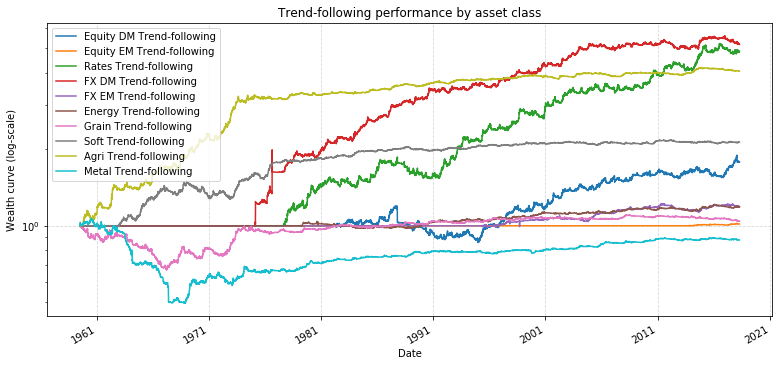

In [10]:
fig, ax = plt.subplots(figsize=(13, 6))
sub_net_returns.fillna(0).add(1).cumprod().plot(logy=True, ax=ax);
ax.set_title('Trend-following performance by asset class')
ax.set_ylabel('Wealth curve (log-scale)');

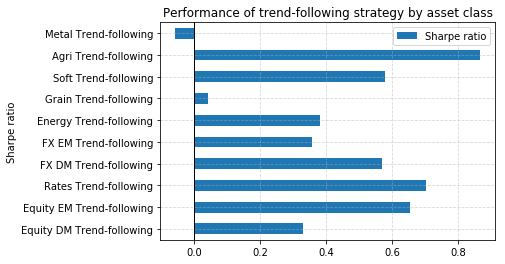

In [11]:
fig, ax = plt.subplots()
(sub_net_returns.add(1).cumprod().pipe(Performance).summary()
 .loc[PerfStats.SHARPE.value, :]
 .to_frame()
 .plot(kind='barh', ax=ax))
ax.set_title('Performance of trend-following strategy by asset class')
ax.set_ylabel(PerfStats.SHARPE.value)
ax.axvline(0, color='black', lw=1);

### Zoom in metal trend-following

Silver futures seem to have caused the drawdown.

In [12]:
metal_sub_returns = engine[0][-1].get_sub_net_returns()

In [13]:
metal_sub_returns = metal_sub_returns.rename(columns=rename_contract)

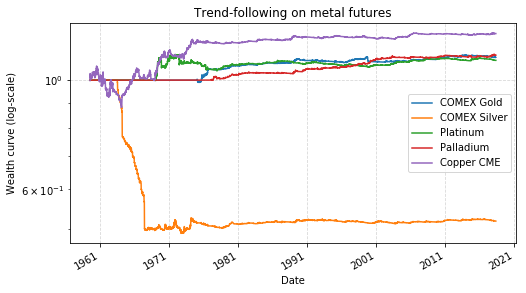

In [14]:
fig, ax = plt.subplots(figsize=(8, 4.5))
metal_sub_returns.fillna(0).add(1).cumprod().plot(logy=True, ax=ax);
ax.set_title('Trend-following on metal futures')
ax.set_ylabel('Wealth curve (log-scale)');

Let's check with the long-only performance of the silver futures in order to see if this drawdown makes sense.

In [15]:
silver_lo_symbol = library.list_symbols(lo_ticker='CME_SI')[0]
silver_lo = library.read(silver_lo_symbol).data

Silver futures in 1967 bounced up largely after the gradual drawdown in the previous years. Actually there was a big surge in silver price according to Wikipedia (https://en.wikipedia.org/wiki/Silver_as_an_investment), so this price change is likely to be legit.

This behaviour is obviously not suitable for trend-following. 

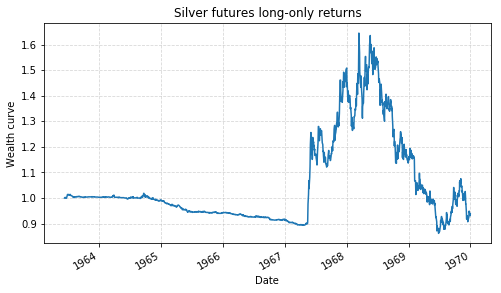

In [16]:
fig, ax = plt.subplots(figsize=(8, 4.5))
silver_lo.get_final_net_returns()[:'1969-12-31'].add(1).cumprod().plot(ax=ax);
ax.set_ylabel('Wealth curve')
ax.set_title('Silver futures long-only returns');

# Positions

The bar chart below shows the latest positions for each futures contract. Generally positions are muted except the government bond futures because of the lack of trends.

In [17]:
latest_position = pd.concat([sub_engine.get_sub_positions().tail(1) 
                             for sub_engine in engine[0]], axis=1)

In [18]:
latest_position = latest_position.rename(columns=rename_contract)

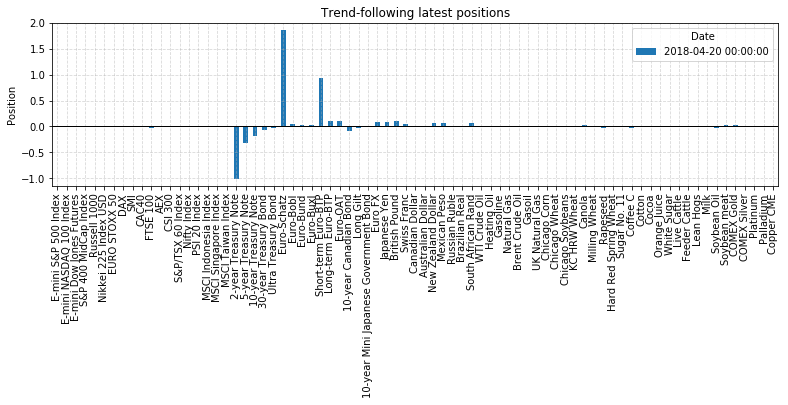

In [19]:
fig, ax = plt.subplots(figsize=(13, 3))
latest_position.T.plot(kind='bar', ax=ax);
ax.set_ylabel('Position')
ax.set_title('Trend-following latest positions')
ax.axhline(0, color='black', lw=1);